In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression


# Data Pre-Processing

In [153]:
#read dataset
data='/content/features_matrix.csv'
dm = pd.read_csv(data)

In [154]:
dm.shape


(6312, 54)

In [155]:
print(f"Number of Rows: {dm.shape[0]}")
print(f"Number of Columns: {dm.shape[1]}")

Number of Rows: 6312
Number of Columns: 54


In [156]:
dm.head()

,reqId,flag,numOfParams,numOfBools,numOfIds,numOfBlobs,reqLen,createInPath,createInParams,addInPath,...,subscribeInParams,signInPath,signInParams,viewInPath,viewInParams,isPUT,isDELETE,isPOST,isGET,isOPTIONS
0,6,n,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,n,1,0,0,1,1519,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18,n,1,0,0,0,629,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,25,n,1,0,0,0,3365,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,77,n,1,0,0,0,567,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [157]:
col_names = dm.columns

col_names


Index(['reqId', 'flag', 'numOfParams', 'numOfBools', 'numOfIds', 'numOfBlobs',
       'reqLen', 'createInPath', 'createInParams', 'addInPath', 'addInParams',
       'setInPath', 'setInParams', 'deleteInPath', 'deleteInParams',
       'updateInPath', 'updateInParams', 'removeInPath', 'removeInParams',
       'friendInPath', 'friendInParams', 'settingInPath', 'settingInParams',
       'passwordInPath', 'passwordInParams', 'tokenInPath', 'tokenInParams',
       'changeInPath', 'changeInParams', 'actionInPath', 'actionInParams',
       'payInPath', 'payInParams', 'loginInPath', 'loginInParams',
       'logoutInPath', 'logoutInParams', 'postInPath', 'postInParams',
       'commentInPath', 'commentInParams', 'followInPath', 'followInParams',
       'subscribeInPath', 'subscribeInParams', 'signInPath', 'signInParams',
       'viewInPath', 'viewInParams', 'isPUT', 'isDELETE', 'isPOST', 'isGET',
       'isOPTIONS'],
      dtype='object')

In [158]:
dm['flag'].value_counts()

,count
flag,
n,5078
y,939
u,241
m,54


we will removing flag{u,m} because we focuce on sensitive or insensitive request


In [159]:
# Remove rows where 'flag' is 'u' or 'm'
filtered_dataset = dm[~dm['flag'].isin(['u', 'm'])]

**later**   
we can delete the features(isPUT,isDELETE,isOPTIONS)because of " we filtered out any HTTP request whose method was different from GET and POST. The rationale of this last choice is that PUT and DELETE requests turned out to be all sensitive, while OPTIONS requests were all insensitive," it is from paper

In [160]:
#columns_to_drop = ['isPUT', 'isDELETE', 'isOPTIONS']

In [161]:
#filtered_dataset = filtered_dataset.drop(columns=columns_to_drop)

In [162]:
print(f"Number of Rows: {filtered_dataset.shape[0]}")
print(f"Number of Columns: {filtered_dataset.shape[1]}")

Number of Rows: 6017
Number of Columns: 54


In [163]:
#col_names = filtered_dataset.columns

#col_names

**Check for duplicates**

In [164]:
print("number of duplicated rows:")
dm.duplicated().sum()

number of duplicated rows:


124

So, we have 124 dupicated records(requests) which we'll delete

In [165]:
# Remove duplicate rows
filtered_dataset = filtered_dataset.drop_duplicates()

**Mapping 'flag' values to integers**

In [166]:
# Map the 'flag' values to integers
flag_mapping = {'n': 0, 'y': 1}
filtered_dataset['flag'] = filtered_dataset['flag'].map(flag_mapping)

# Convert 'flag' to int64
filtered_dataset['flag'] = filtered_dataset['flag'].astype('int64')


In [167]:
dm = filtered_dataset.select_dtypes(include=[int, float])

In [64]:
#filtered_dataset.to_csv('CSRF_dataset.csv', index=False)

In [168]:
from itertools import combinations
import pandas as pd

features = dm.columns

correlation_results = []

for feature1, feature2 in combinations(features, 2):
    correlation = dm[feature1].corr(dm[feature2])
    correlation_results.append({
        'Feature 1': feature1,
        'Feature 2': feature2,
        'Correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)

correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

correlation_df


,Feature 1,Feature 2,Correlation
537,setInPath,settingInPath,0.887148
105,numOfParams,numOfBools,0.850801
107,numOfParams,numOfBlobs,0.616567
106,numOfParams,numOfIds,0.449500
579,setInParams,settingInParams,0.399617
...,...,...,...
1176,actionInParams,isGET,-0.176241
348,reqLen,isGET,-0.180684
1219,payInParams,isGET,-0.266589
103,flag,isGET,-0.345404


 - **Now, we can draw heatmap to show correlations between features**

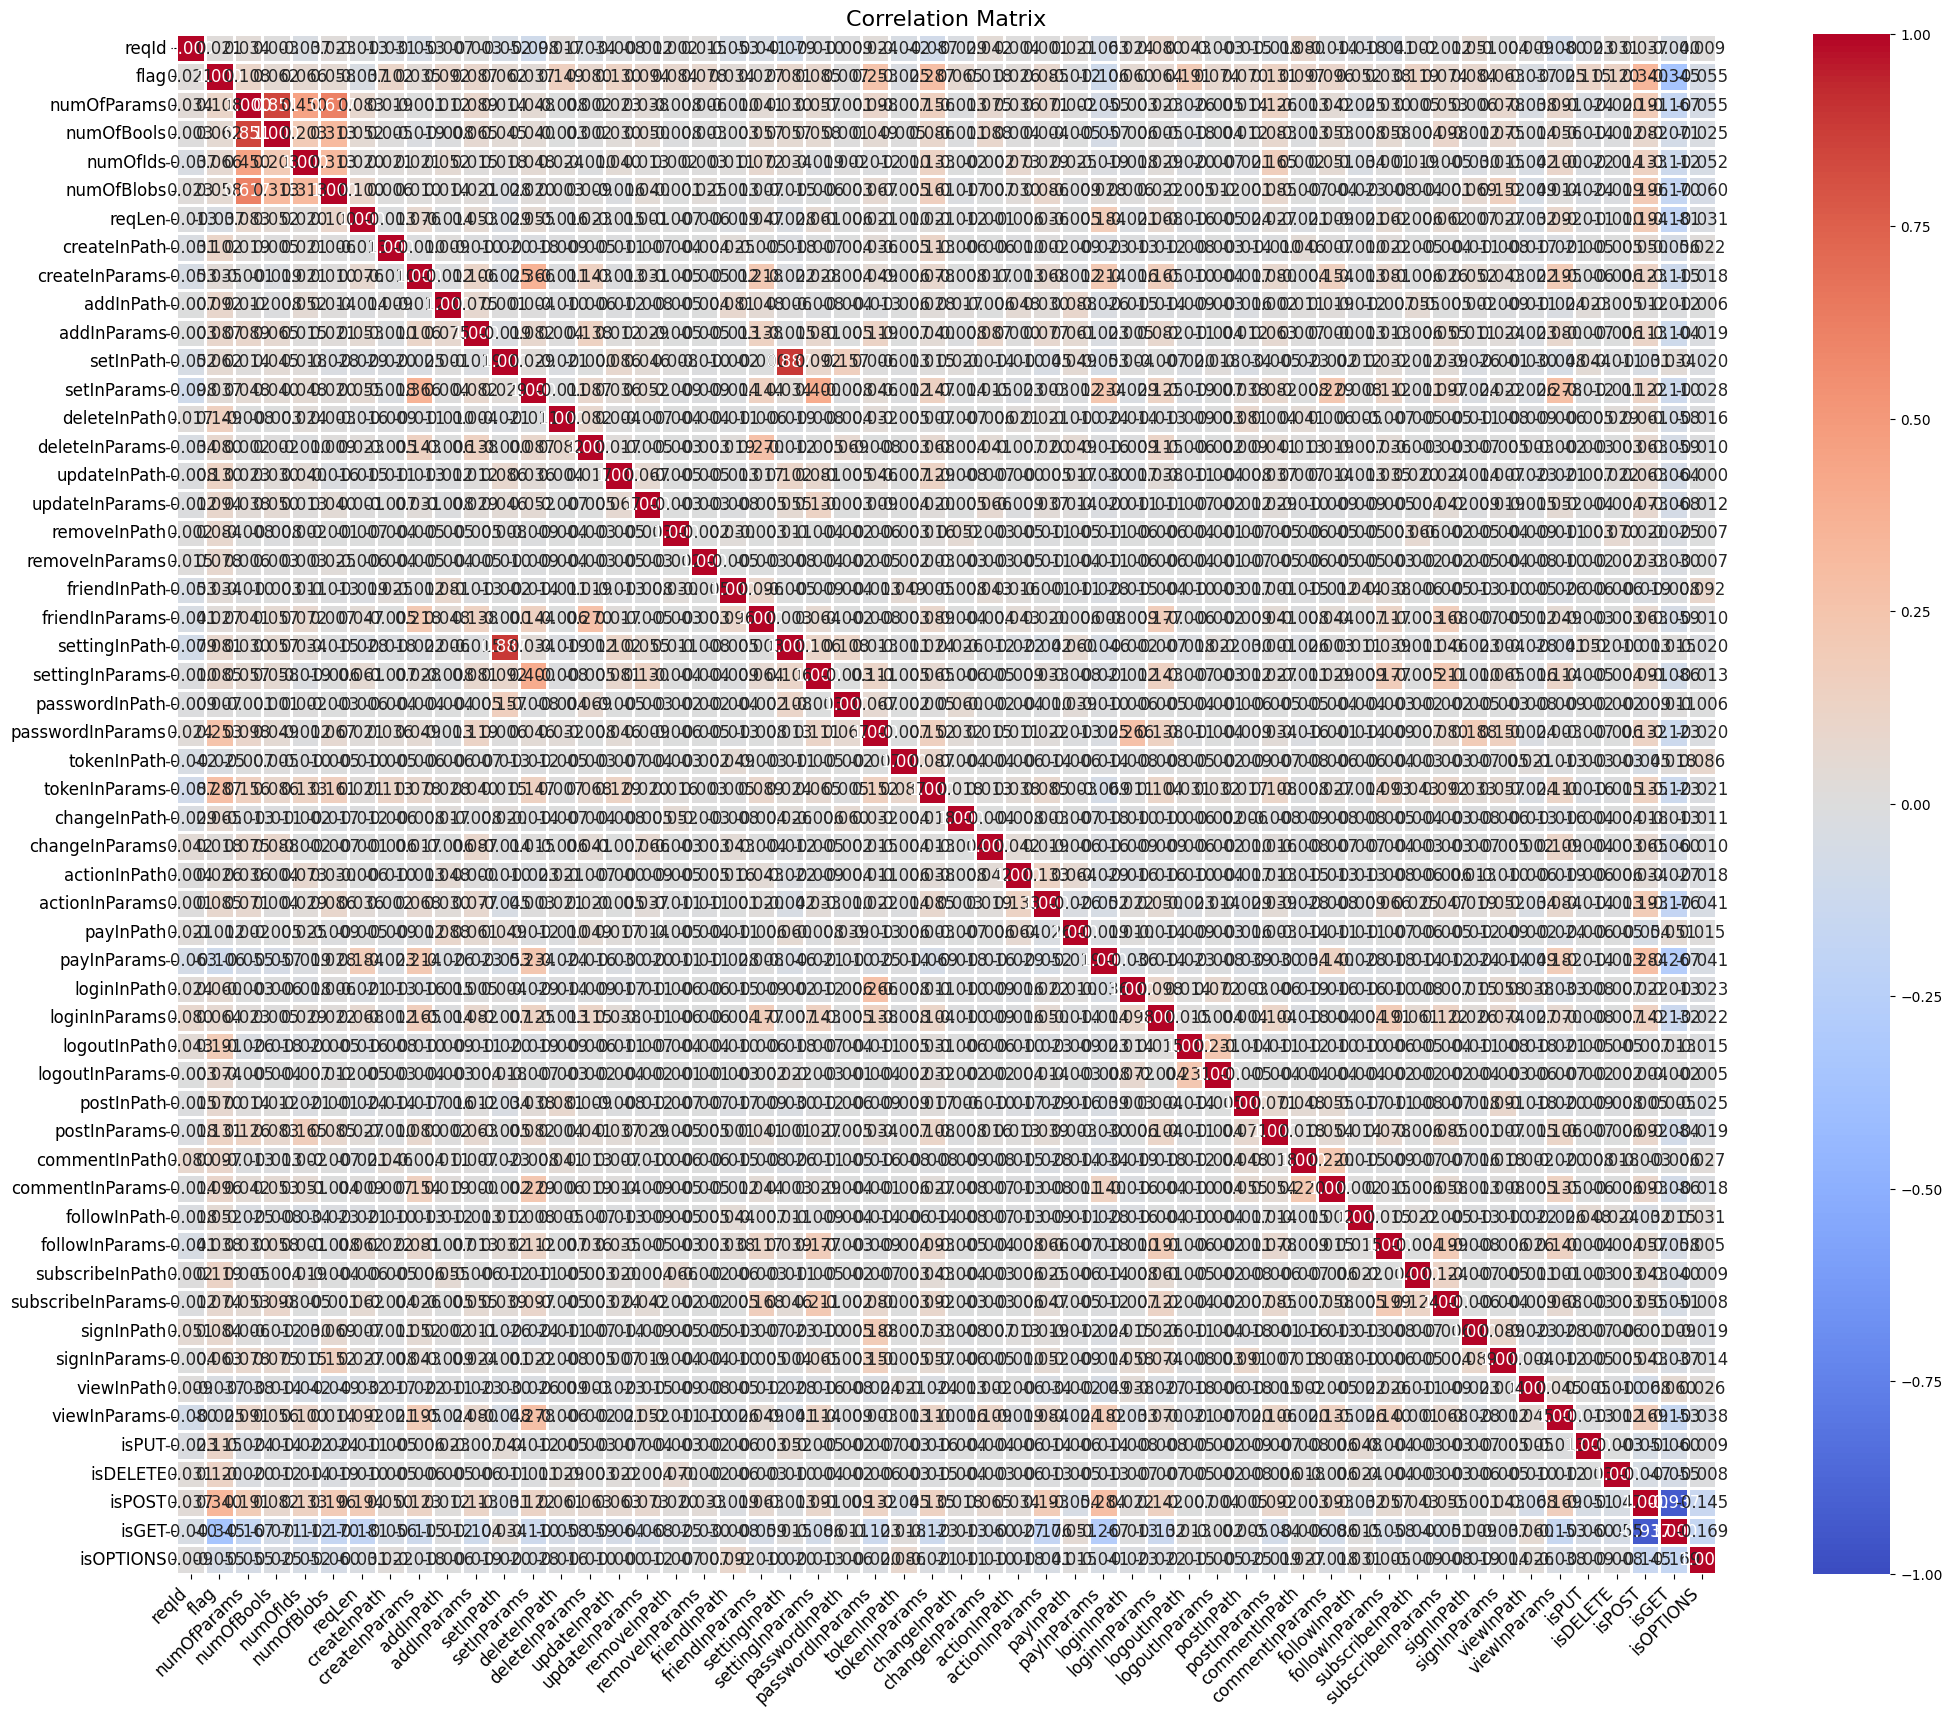

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 20))

corr_matrix = dm.corr()

sns.heatmap(corr_matrix,
            annot=True,
            linewidths=0.8,
            fmt=".3f",
            cmap="coolwarm",
            vmin=-1, vmax=1,
            square=True,
            annot_kws={"fontsize": 12})


plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')

plt.show()


In [126]:
def print_high_correlation_features(corr_matrix, threshold=0.5):
  """
  Prints pairs of features with a correlation greater than the specified threshold.

  Args:
    corr_matrix: The correlation matrix.
    threshold: The correlation threshold.
  """

  # Create a list to store pairs of highly correlated features
  high_corr_pairs = []

  # Get the feature names
  features = corr_matrix.columns

  # Find pairs of features with a correlation greater than the threshold
  for i in range(len(features)):
      for j in range(i+1, len(features)):
          feature1 = features[i]
          feature2 = features[j]
          correlation = corr_matrix.loc[feature1, feature2]
          if abs(correlation) > threshold:
              high_corr_pairs.append((feature1, feature2, correlation))

  # Print the results
  if high_corr_pairs:
      print(f"Features with correlation greater than {threshold}:")
      for pair in high_corr_pairs:
          print(f"{pair[0]} and {pair[1]}: {pair[2]:.3f}")
  else:
      print(f"No feature pairs have a correlation greater than {threshold}.")

# Use the function to print highly correlated features
print_high_correlation_features(corr_matrix, threshold=0.5)

Features with correlation greater than 0.5:
numOfParams and numOfBools: 0.851
numOfParams and numOfBlobs: 0.617
setInPath and settingInPath: 0.887
isPOST and isGET: -0.937


We are removing the numOfBools and numOfBlobs columns because of their high correlation with numOfParams (0.851 and 0.617 respectively). High correlation indicates that these columns carry similar information. To reduce redundancy and potentially improve the performance of models by lowering dimensionality, it's logical to retain only numOfParams while removing the other two columns.

In [127]:
columns_to_drop = ['numOfBools', 'numOfBlobs']

In [128]:
filtered_dataset = filtered_dataset.drop(columns=columns_to_drop)

In [129]:
col_names = filtered_dataset.columns

col_names

Index(['reqId', 'flag', 'numOfParams', 'numOfIds', 'reqLen', 'createInPath',
       'createInParams', 'addInPath', 'addInParams', 'setInPath',
       'setInParams', 'deleteInPath', 'deleteInParams', 'updateInPath',
       'updateInParams', 'removeInPath', 'removeInParams', 'friendInPath',
       'friendInParams', 'settingInPath', 'settingInParams', 'passwordInPath',
       'passwordInParams', 'tokenInPath', 'tokenInParams', 'changeInPath',
       'changeInParams', 'actionInPath', 'actionInParams', 'payInPath',
       'payInParams', 'loginInPath', 'loginInParams', 'logoutInPath',
       'logoutInParams', 'postInPath', 'postInParams', 'commentInPath',
       'commentInParams', 'followInPath', 'followInParams', 'subscribeInPath',
       'subscribeInParams', 'signInPath', 'signInParams', 'viewInPath',
       'viewInParams', 'isPUT', 'isDELETE', 'isPOST', 'isGET', 'isOPTIONS'],
      dtype='object')

In [130]:
correlation = dm.corr()
correlation['flag'].sort_values(ascending=False)

,flag
flag,1.000000
isPOST,0.339583
tokenInParams,0.286760
passwordInParams,0.253394
logoutInPath,0.190779
deleteInPath,0.148668
postInParams,0.131454
updateInPath,0.130006
isDELETE,0.120383
subscribeInPath,0.119280


**Now we do not focus on the correlation between features**

In [131]:
print(f"Number of Rows: {filtered_dataset.shape[0]}")
print(f"Number of Columns: {filtered_dataset.shape[1]}")

Number of Rows: 5894
Number of Columns: 52


In [132]:
from google.colab import files
# Save the modified dataset to a new CSV file
modified_file_path = '//content//CSRF_dataset.csv'
filtered_dataset.to_csv(modified_file_path, index=False)
files.download(modified_file_path)
print("CSRF dataset saved successfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSRF dataset saved successfully.


In [133]:
df = pd.read_csv('CSRF_dataset.csv')

In [134]:
df.head()


,reqId,flag,numOfParams,numOfIds,reqLen,createInPath,createInParams,addInPath,addInParams,setInPath,...,subscribeInParams,signInPath,signInParams,viewInPath,viewInParams,isPUT,isDELETE,isPOST,isGET,isOPTIONS
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,0,1,0,1519,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,18,0,1,0,629,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,25,0,1,0,3365,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,77,0,1,0,567,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [135]:
round(df.describe(),3)

,reqId,flag,numOfParams,numOfIds,reqLen,createInPath,createInParams,addInPath,addInParams,setInPath,...,subscribeInParams,signInPath,signInParams,viewInPath,viewInParams,isPUT,isDELETE,isPOST,isGET,isOPTIONS
count,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,...,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000,5894.000
mean,9714.949,0.158,3.845,0.382,544.962,0.008,0.013,0.011,0.013,0.046,...,0.002,0.014,0.008,0.036,0.051,0.003,0.003,0.444,0.524,0.025
std,9193.030,0.365,8.900,0.994,2737.012,0.089,0.111,0.102,0.115,0.210,...,0.049,0.117,0.087,0.187,0.221,0.057,0.052,0.497,0.499,0.157
min,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2493.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,6735.000,0.000,1.000,0.000,47.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,13792.000,0.000,4.000,0.000,346.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000
max,43155.000,1.000,158.000,23.000,130739.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [136]:
df['flag'].value_counts()

,count
flag,
0,4962
1,932


n or 0: Normal or non-sensitive request.   

y or 1: Sensitive request.

In [137]:
df['flag'].value_counts()/float(len(df))

,count
flag,
0,0.841873
1,0.158127


In [138]:
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

Number of Rows: 5894
Number of Columns: 52


- **Looking Datatypes of the columns**

In [139]:
df.dtypes

,0
reqId,int64
flag,int64
numOfParams,int64
numOfIds,int64
reqLen,int64
createInPath,int64
createInParams,int64
addInPath,int64
addInParams,int64
setInPath,int64


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5894 entries, 0 to 5893
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   reqId              5894 non-null   int64
 1   flag               5894 non-null   int64
 2   numOfParams        5894 non-null   int64
 3   numOfIds           5894 non-null   int64
 4   reqLen             5894 non-null   int64
 5   createInPath       5894 non-null   int64
 6   createInParams     5894 non-null   int64
 7   addInPath          5894 non-null   int64
 8   addInParams        5894 non-null   int64
 9   setInPath          5894 non-null   int64
 10  setInParams        5894 non-null   int64
 11  deleteInPath       5894 non-null   int64
 12  deleteInParams     5894 non-null   int64
 13  updateInPath       5894 non-null   int64
 14  updateInParams     5894 non-null   int64
 15  removeInPath       5894 non-null   int64
 16  removeInParams     5894 non-null   int64
 17  friendInPath  

**Check for nulls**

In [141]:
pd.DataFrame(df.isnull().sum(), columns=['Number of missing values'])

,Number of missing values
reqId,0
flag,0
numOfParams,0
numOfIds,0
reqLen,0
createInPath,0
createInParams,0
addInPath,0
addInParams,0
setInPath,0


So, we don't have any missing values.

In [142]:
df.isna().sum()

,0
reqId,0
flag,0
numOfParams,0
numOfIds,0
reqLen,0
createInPath,0
createInParams,0
addInPath,0
addInParams,0
setInPath,0


In [143]:
print("number of duplicated rows:")
df.duplicated().sum()

number of duplicated rows:


0

# Visualize the Data

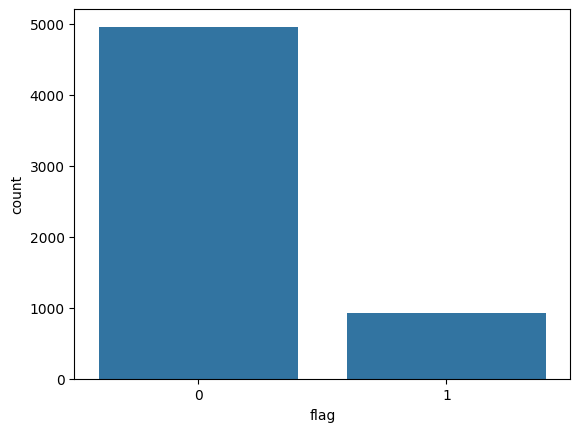

In [144]:
sns.countplot(x=df['flag'])

plt.show()

Text(0, 0.5, 'numOfIds')

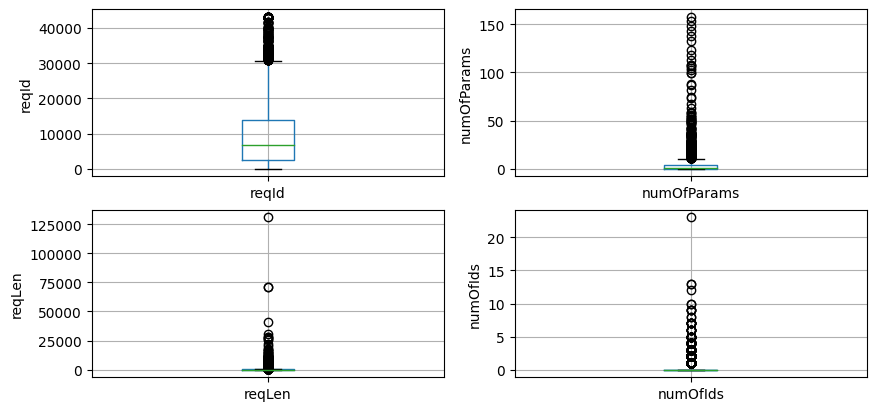

In [145]:
plt.figure(figsize=(10,10))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='reqId')
fig.set_title('')
fig.set_ylabel('reqId')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='numOfParams')
fig.set_title('')
fig.set_ylabel('numOfParams')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='reqLen')
fig.set_title('')
fig.set_ylabel('reqLen')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='numOfIds')
fig.set_title('')
fig.set_ylabel('numOfIds')

Text(0, 0.5, 'setInParams')

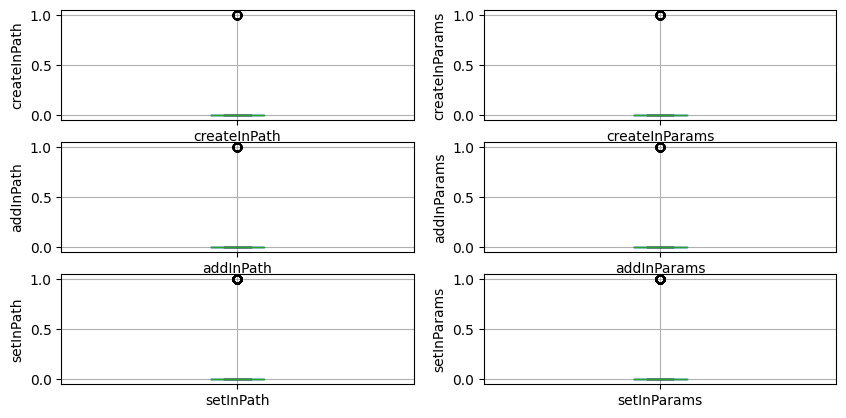

In [146]:
plt.figure(figsize=(10,10))


plt.subplot(6, 2, 1)
fig = df.boxplot(column='createInPath')
fig.set_title('')
fig.set_ylabel('createInPath')


plt.subplot(6, 2, 2)
fig = df.boxplot(column='createInParams')
fig.set_title('')
fig.set_ylabel('createInParams')


plt.subplot(6, 2, 3)
fig = df.boxplot(column='addInPath')
fig.set_title('')
fig.set_ylabel('addInPath')

plt.subplot(6, 2, 4)
fig = df.boxplot(column='addInParams')
fig.set_title('')
fig.set_ylabel('addInParams')

plt.subplot(6, 2, 5)
fig = df.boxplot(column='setInPath')
fig.set_title('')
fig.set_ylabel('setInPath')

plt.subplot(6, 2, 6)
fig = df.boxplot(column='setInParams')
fig.set_title('')
fig.set_ylabel('setInParams')


Text(0, 0.5, 'settingInPath')

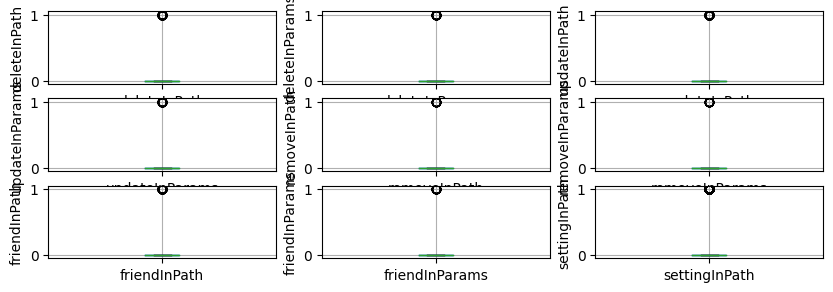

In [147]:
plt.figure(figsize=(10,10))


plt.subplot(9, 3, 1)
fig = df.boxplot(column='deleteInPath')
fig.set_title('')
fig.set_ylabel('deleteInPath')


plt.subplot(9, 3, 2)
fig = df.boxplot(column='deleteInParams')
fig.set_title('')
fig.set_ylabel('deleteInParams')


plt.subplot(9, 3, 3)
fig = df.boxplot(column='updateInPath')
fig.set_title('')
fig.set_ylabel('updateInPath')

plt.subplot(9, 3, 4)
fig = df.boxplot(column='updateInParams')
fig.set_title('')
fig.set_ylabel('updateInParams')

plt.subplot(9, 3, 5)
fig = df.boxplot(column='removeInPath')
fig.set_title('')
fig.set_ylabel('removeInPath')

plt.subplot(9, 3, 6)
fig = df.boxplot(column='removeInParams')
fig.set_title('')
fig.set_ylabel('removeInParams')

plt.subplot(9, 3, 7)
fig = df.boxplot(column='friendInPath')
fig.set_title('')
fig.set_ylabel('friendInPath')

plt.subplot(9, 3, 8)
fig = df.boxplot(column='friendInParams')
fig.set_title('')
fig.set_ylabel('friendInParams')

plt.subplot(9, 3, 9)
fig = df.boxplot(column='settingInPath')
fig.set_title('')
fig.set_ylabel('settingInPath')


Text(0, 0.5, 'actionInParams')

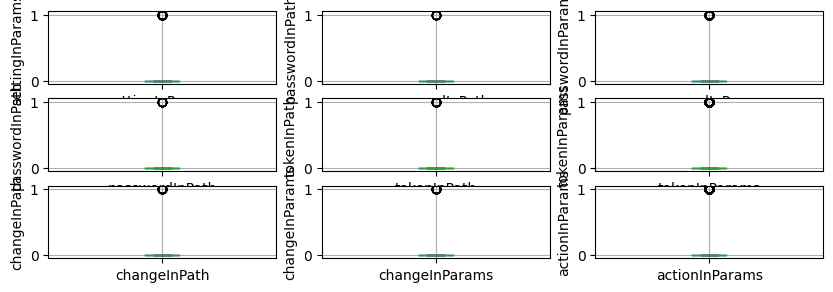

In [148]:
plt.figure(figsize=(10,10))


plt.subplot(9, 3, 1)
fig = df.boxplot(column='settingInParams')
fig.set_title('')
fig.set_ylabel('settingInParams')


plt.subplot(9, 3, 2)
fig = df.boxplot(column='passwordInPath')
fig.set_title('')
fig.set_ylabel('passwordInPath')


plt.subplot(9, 3, 3)
fig = df.boxplot(column='passwordInParams')
fig.set_title('')
fig.set_ylabel('passwordInParams')

plt.subplot(9, 3, 4)
fig = df.boxplot(column='passwordInPath')
fig.set_title('')
fig.set_ylabel('passwordInPath')

plt.subplot(9, 3, 5)
fig = df.boxplot(column='tokenInPath')
fig.set_title('')
fig.set_ylabel('tokenInPath')

plt.subplot(9, 3, 6)
fig = df.boxplot(column='tokenInParams')
fig.set_title('')
fig.set_ylabel('tokenInParams')

plt.subplot(9, 3, 7)
fig = df.boxplot(column='changeInPath')
fig.set_title('')
fig.set_ylabel('changeInPath')

plt.subplot(9, 3, 8)
fig = df.boxplot(column='changeInParams')
fig.set_title('')
fig.set_ylabel('changeInParams')

plt.subplot(9, 3, 9)
fig = df.boxplot(column='actionInParams')
fig.set_title('')
fig.set_ylabel('actionInParams')


Text(0, 0.5, 'commentInPath')

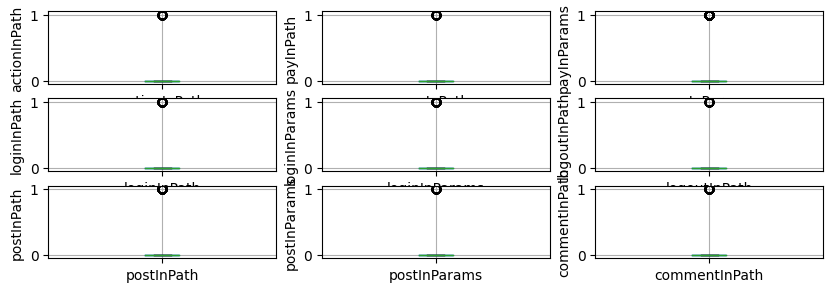

In [149]:
plt.figure(figsize=(10,10))


plt.subplot(9, 3, 1)
fig = df.boxplot(column='actionInPath')
fig.set_title('')
fig.set_ylabel('actionInPath')


plt.subplot(9, 3, 2)
fig = df.boxplot(column='payInPath')
fig.set_title('')
fig.set_ylabel('payInPath')


plt.subplot(9, 3, 3)
fig = df.boxplot(column='payInParams')
fig.set_title('')
fig.set_ylabel('payInParams')

plt.subplot(9, 3, 4)
fig = df.boxplot(column='loginInPath')
fig.set_title('')
fig.set_ylabel('loginInPath')

plt.subplot(9, 3, 5)
fig = df.boxplot(column='loginInParams')
fig.set_title('')
fig.set_ylabel('loginInParams')

plt.subplot(9, 3, 6)
fig = df.boxplot(column='logoutInPath')
fig.set_title('')
fig.set_ylabel('logoutInPath')

plt.subplot(9, 3, 7)
fig = df.boxplot(column='postInPath')
fig.set_title('')
fig.set_ylabel('postInPath')

plt.subplot(9, 3, 8)
fig = df.boxplot(column='postInParams')
fig.set_title('')
fig.set_ylabel('postInParams')

plt.subplot(9, 3, 9)
fig = df.boxplot(column='commentInPath')
fig.set_title('')
fig.set_ylabel('commentInPath')


Text(0, 0.5, 'viewInParams')

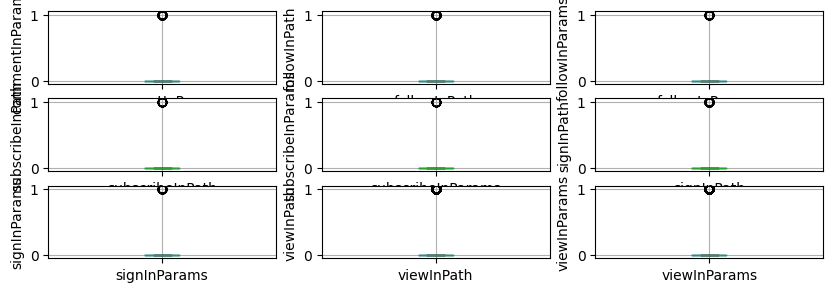

In [150]:
plt.figure(figsize=(10,10))


plt.subplot(9, 3, 1)
fig = df.boxplot(column='commentInParams')
fig.set_title('')
fig.set_ylabel('commentInParams')


plt.subplot(9, 3, 2)
fig = df.boxplot(column='followInPath')
fig.set_title('')
fig.set_ylabel('followInPath')


plt.subplot(9, 3, 3)
fig = df.boxplot(column='followInParams')
fig.set_title('')
fig.set_ylabel('followInParams')

plt.subplot(9, 3, 4)
fig = df.boxplot(column='subscribeInPath')
fig.set_title('')
fig.set_ylabel('subscribeInPath')

plt.subplot(9, 3, 5)
fig = df.boxplot(column='subscribeInParams')
fig.set_title('')
fig.set_ylabel('subscribeInParams')

plt.subplot(9, 3, 6)
fig = df.boxplot(column='signInPath')
fig.set_title('')
fig.set_ylabel('signInPath')

plt.subplot(9, 3, 7)
fig = df.boxplot(column='signInParams')
fig.set_title('')
fig.set_ylabel('signInParams')

plt.subplot(9, 3, 8)
fig = df.boxplot(column='viewInPath')
fig.set_title('')
fig.set_ylabel('viewInPath')

plt.subplot(9, 3, 9)
fig = df.boxplot(column='viewInParams')
fig.set_title('')
fig.set_ylabel('viewInParams')


Text(0, 0.5, 'isOPTIONS')

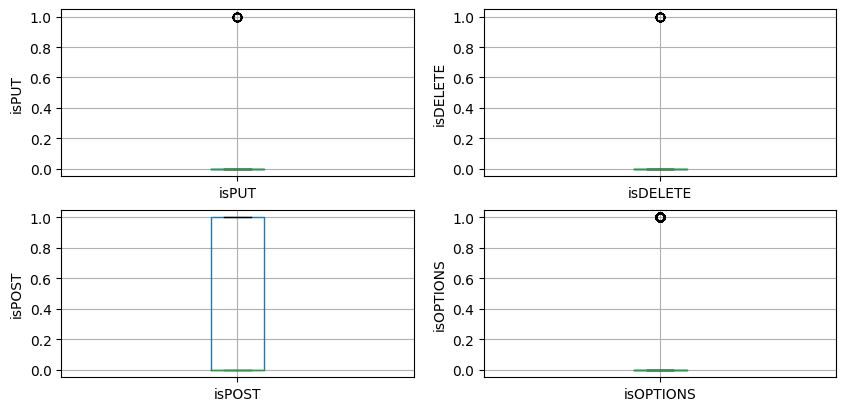

In [151]:
plt.figure(figsize=(10,10))


plt.subplot(4, 2, 1)
fig = df.boxplot(column='isPUT')
fig.set_title('')
fig.set_ylabel('isPUT')


plt.subplot(4, 2, 2)
fig = df.boxplot(column='isDELETE')
fig.set_title('')
fig.set_ylabel('isDELETE')


plt.subplot(4, 2, 3)
fig = df.boxplot(column='isPOST')
fig.set_title('')
fig.set_ylabel('isPOST')


plt.subplot(4, 2, 4)
fig = df.boxplot(column='isOPTIONS')
fig.set_title('')
fig.set_ylabel('isOPTIONS')